In [4]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from contrast_correct import contrast_correction


225.7679375


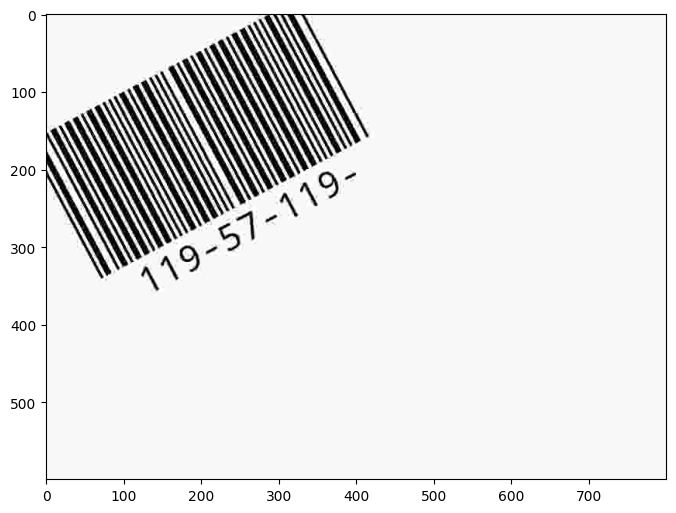

In [5]:
img_path = "test cases/09 - e3del el soora ya3ammm.jpg"

img = cv2.imread(img_path)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap="gray")

225.7679375


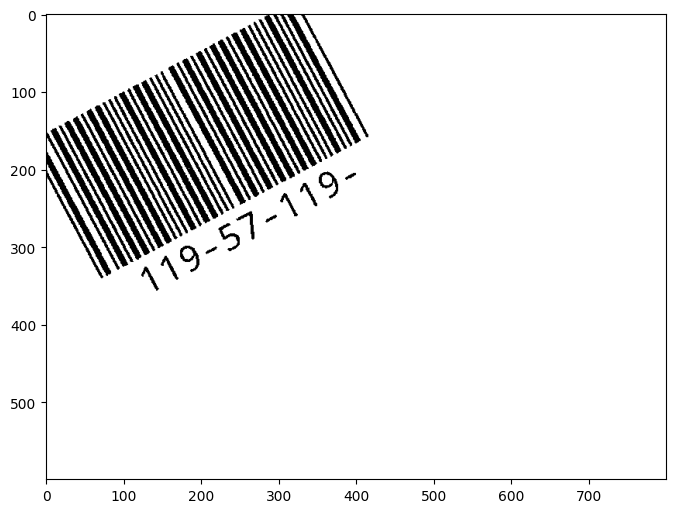

In [61]:
thresholded_image = contrast_correction(img)
plt.figure(figsize=(8, 8))
plt.imshow(thresholded_image, cmap="gray")

Preprocessed image for rotation.
Detected angle: 62.01 degrees
Image rotated to correct orientation.
Corrected image saved to corrected_barcode.jpg.


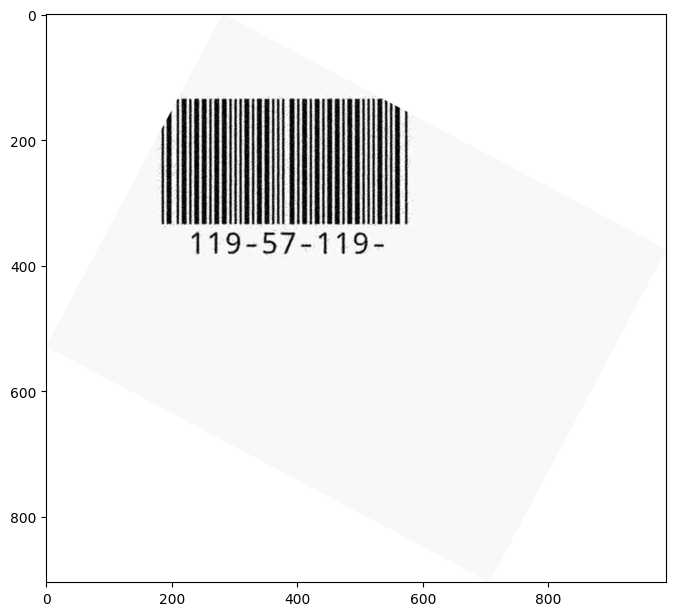

In [85]:
import cv2
import numpy as np

def preprocess_image(image):
    """Convert the image to grayscale."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    """Apply binary thresholding to the grayscale image."""
    # Since the background is white, use THRESH_BINARY_INV to make barcode lines white
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

def find_orientation(thresh):
    """Detect edges using Canny edge detector."""
    edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
    """
    Find the angle of the barcode.

    This function uses the Hough Line Transform to detect lines and computes their angle.
    """
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    angles = []

    if lines is None:
        return 0  # Assume no rotation if no lines are detected.

    for line in lines:
        x1, y1, x2, y2 = line[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        angles.append(angle)

    if len(angles) == 0:
        return 0

    # Compute the median angle
    median_angle = np.median(angles)
    return median_angle

def rotate_image(image, angle):
    """Rotate the image by the specified angle."""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Compute the rotation matrix
    M = cv2.getRotationMatrix2D(center, -(90-angle), 1.0)

    # Compute sine and cosine (for bounding box calculation)
    abs_cos = abs(M[0, 0])
    abs_sin = abs(M[0, 1])

    # Compute new bounding dimensions
    bound_w = int(h * abs_sin + w * abs_cos)
    bound_h = int(h * abs_cos + w * abs_sin)

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += bound_w / 2 - center[0]
    M[1, 2] += bound_h / 2 - center[1]

    # Perform the rotation
    rotated = cv2.warpAffine(image, M, (bound_w, bound_h), flags=cv2.INTER_LINEAR, borderValue=(255,255,255))
    return rotated

def rotate_barcode(image, output_path=None):
    """Preprocess the barcode image and optionally save the corrected image."""

    # Convert to grayscale
    thresh = preprocess_image(image)
    print("Preprocessed image for rotation.")

    # Find orientation
    angle = find_orientation(thresh)
    print(f"Detected angle: {angle:.2f} degrees")

    # Rotate image to make barcode horizontal
    rotated = rotate_image(image, angle)
    print("Image rotated to correct orientation.")

    # Optionally save the corrected image
    if output_path:
        cv2.imwrite(output_path, rotated)
        print(f"Corrected image saved to {output_path}.")

    return rotated


# Preprocess the barcode image
output_path = "corrected_barcode.jpg"
corrected = rotate_barcode(img, output_path)
plt.figure(figsize=(8, 8))
plt.imshow(corrected, cmap="gray")

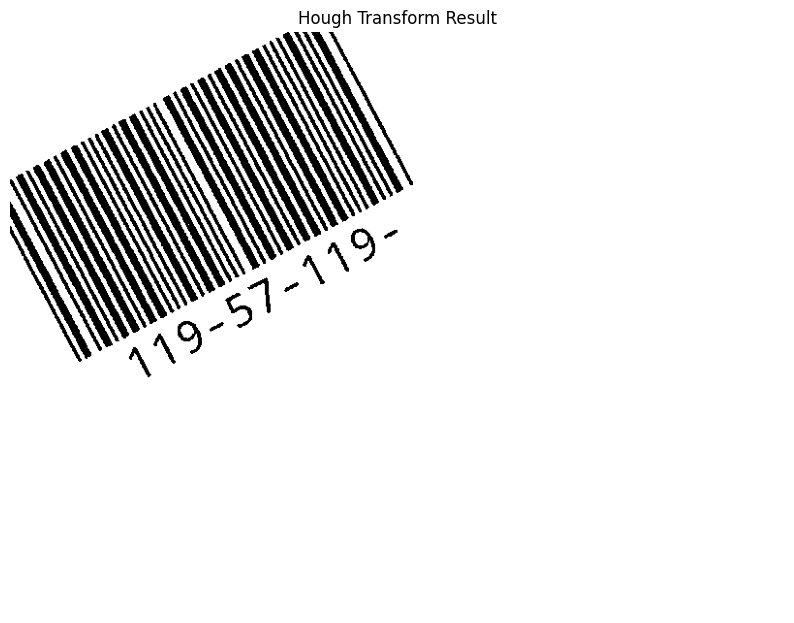

UnboundLocalError: cannot access local variable 'theta' where it is not associated with a value

In [86]:
def apply_hough_transform(image):
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply Canny edge detector
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    # Create a copy of the original image to draw lines on
    hough_image = np.copy(image)

    # Draw the lines on the image
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            print("line", line)
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(hough_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    # Display the result
    plt.figure(figsize=(10, 10))
    plt.title("Hough Transform Result")
    plt.imshow(hough_image, cmap='gray')
    plt.axis("off")
    plt.show()

    return hough_image, theta

# Example usage:
hough_result, theta = apply_hough_transform(thresholded_image)

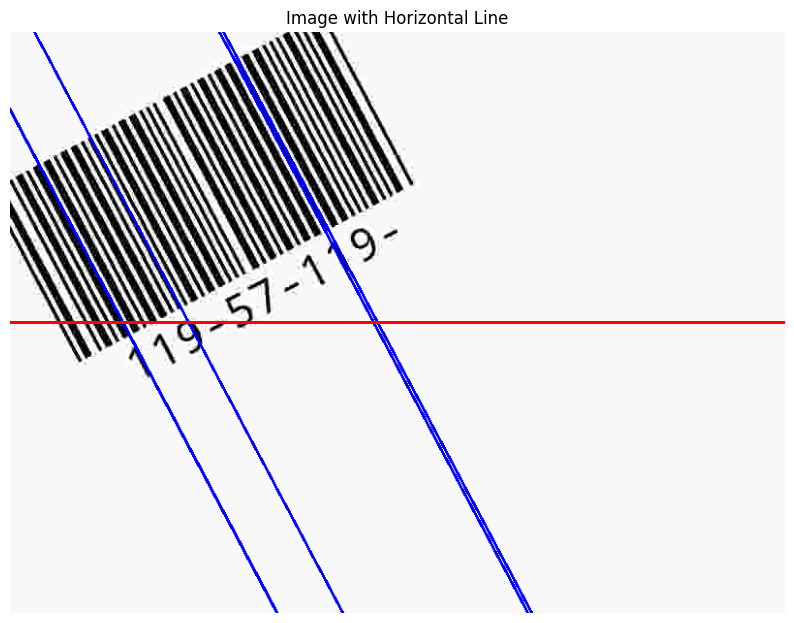

In [43]:
# Draw a horizontal line on the image
start_point = (0, hough_result.shape[0] // 2)
end_point = (hough_result.shape[1], hough_result.shape[0] // 2)
color = (255, 0, 0)  # Blue color in BGR
thickness = 2

# Draw the line
image_with_line = cv2.line(hough_result.copy(), start_point, end_point, color, thickness)

# Display the image with the horizontal line
plt.figure(figsize=(10, 10))
plt.title("Image with Horizontal Line")
plt.imshow(image_with_line, cmap='gray')
plt.axis("off")
plt.show()

In [39]:

# Calculate the angle of the Hough line in degrees
hough_line_angle = np.degrees(theta)

# The horizontal line is at 0 degrees
perpendicular_line_angle = 90

# Calculate the angle between the Hough line and the horizontal line
angle_between_lines = abs(hough_line_angle - perpendicular_line_angle)

print(f"Angle between the Hough line and the horizontal line: {angle_between_lines:.2f} degrees")

Angle between the Hough line and the horizontal line: 62.00 degrees


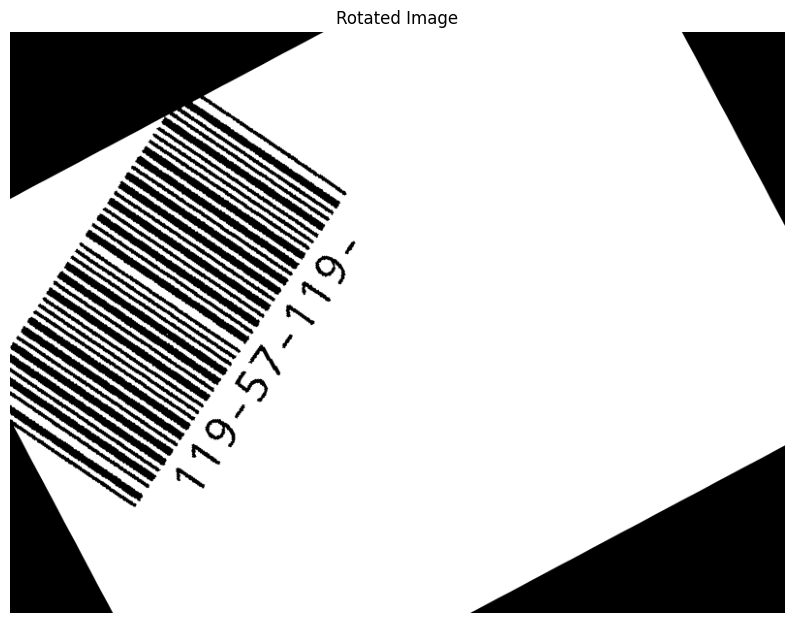

In [72]:
# Calculate the rotation angle to make the angle between lines zero
rotation_angle = perpendicular_line_angle - angle_between_lines

# Get the image dimensions
(h, w) = hough_result.shape[:2]
center = (w // 2, h // 2)

# Compute the rotation matrix
rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

# Rotate the image
rotated_image = cv2.warpAffine(hough_result, rotation_matrix, (w, h))

# Display the rotated image
plt.figure(figsize=(10, 10))
plt.title("Rotated Image")
plt.imshow(rotated_image, cmap='gray')
plt.axis("off")
plt.show()

Rotation shaep: (600, 800, 3)


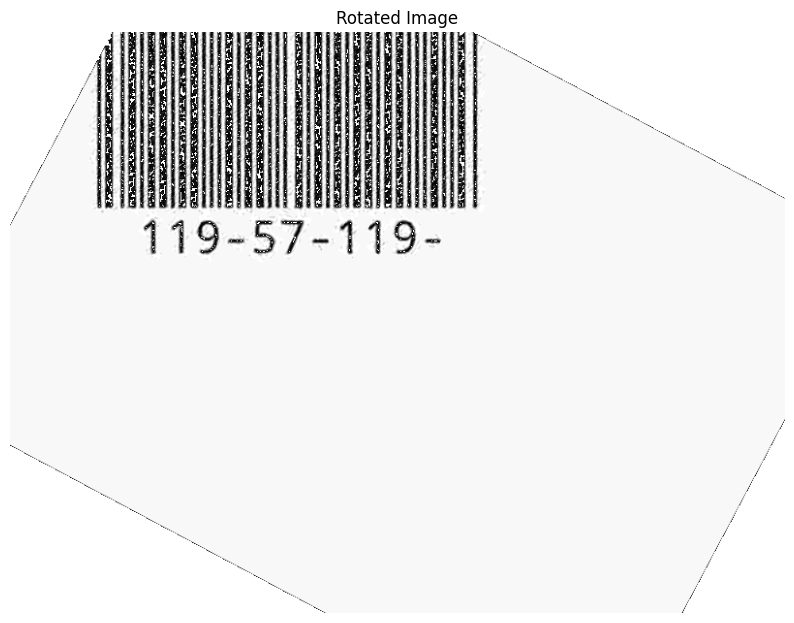

In [58]:
print(f"Rotation shaep: {rotated_image.shape}")
# edit image to be gray
rotated_image_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)
#plot the image
plt.figure(figsize=(10, 10))
plt.title("Rotated Image")
plt.imshow(rotated_image_gray, cmap='gray')
plt.axis("off")
plt.show()

In [76]:
from barcode_detector import process_barcode_image
corrected_gray = cv2.cvtColor(corrected, cv2.COLOR_BGR2GRAY)

cropped = process_barcode_image(corrected_gray)

Bounding Box: x_min=183, y_min=132, x_max=578, y_max=385


Preprocessed image for rotation.
Detected angle: 62.00 degrees
Image rotated to correct orientation.
Corrected image saved to 9.jpg.


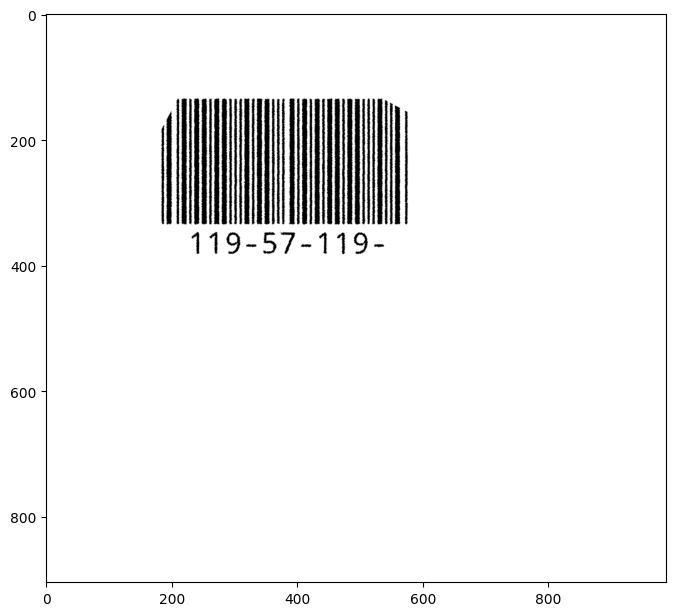

In [89]:
# Preprocess the barcode image
img = cv2.imread("test cases/09 - e3del el soora ya3ammm.jpg")
output_path = "9.jpg"
corrected = rotate_barcode(thresholded_image, output_path)
#apply binarization threshold, to be 0 or 255 only
plt.figure(figsize=(8, 8))
plt.imshow(corrected, cmap="gray")